# Loading the data and required libraries

In [47]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
DIR = "E:/Coding/Summer 2023/data/"

In [4]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Linear Models
## Words, Train and Test

Repartition data

In [10]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2)

Subsample non-readmitted patients to match size of readmitted ones

In [11]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [12]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

Sparse Matrix with word count

In [13]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenize_stem)
vect.fit(df_train['TEXT'].values)

X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)

y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']

Proportion of 1 in test sample

In [14]:
sum(y_test == 1) / sum(y_test == 0)

1.0

## Logistic Regression

In [15]:
grid = {'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]}

model_log = GridSearchCV(LogisticRegression(penalty='l2', max_iter=10000), param_grid=grid)

In [16]:
model_log.fit(X_train_tf, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]})

In [17]:
model_log.best_params_

{'C': 0.0001}

In [18]:
y_train_prob = model_log.predict_proba(X_train_tf)[:,1]
y_test_prob = model_log.predict_proba(X_test_tf)[:,1]

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [20]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7456961290723327 0.6952736740991039
Accuracy	 0.6789891395154553 0.6493848857644992
Precission	 0.7071048815853069 0.6778242677824268
Recall		 0.6111111111111112 0.5694200351493849


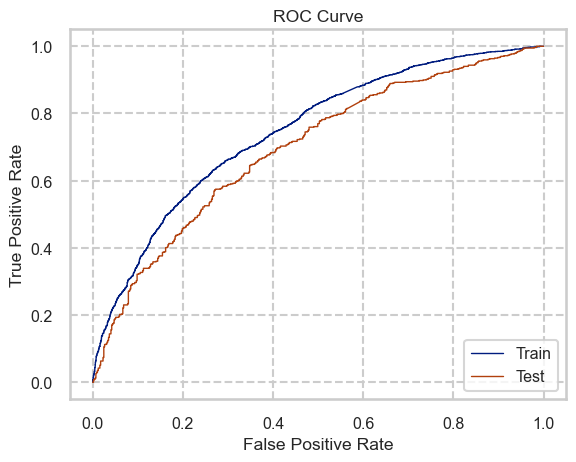

In [21]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/logistic_auroc.pgf')

## Ridge Regression

In [22]:
grid={'alpha': np.arange(10000, 20000, 1000)}
model_ridge = GridSearchCV(Ridge(), param_grid=grid)

In [23]:
model_ridge.fit(X_train_tf, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000])})

In [24]:
model_ridge.best_params_

{'alpha': 15000}

In [25]:
y_train_reg = model_ridge.predict(X_train_tf)
y_test_reg = model_ridge.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_reg)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_reg)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [27]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7885661138365267 0.7037490618079386
Accuracy	 0.7128237259816207 0.6467486818980668
Precission	 0.7476908118619349 0.6750524109014675
Recall		 0.6424394319131161 0.5659050966608085


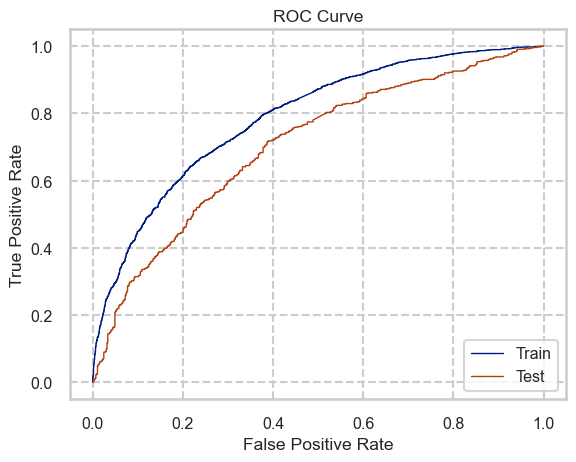

In [28]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/ridge_auroc.pgf')

## Lasso Regression

In [29]:
grid = {'alpha':[0.1,0.01,0.001,0.0001]}
model_lasso = GridSearchCV(Lasso(), param_grid=grid)

In [30]:
model_lasso.fit(X_train_tf, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.01, 0.001, 0.0001]})

In [31]:
model_lasso.best_params_

{'alpha': 0.01}

In [32]:
y_train_reg = model_lasso.predict(X_train_tf)
y_test_reg = model_lasso.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [34]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7456961290723327 0.6952736740991039
Accuracy	 0.6819131161236425 0.6353251318101933
Precission	 0.7174238642036944 0.6610878661087866
Recall		 0.600250626566416 0.5553602811950791


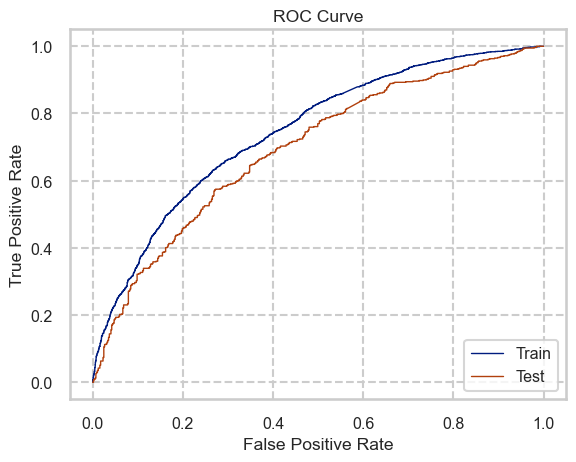

In [35]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/lasso_auroc.pgf')

## ElasticNet

In [36]:
np.arange(0.1, 1.0, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [37]:
grid = {
    #"max_iter": [1, 2, 3, 4, 5],
    "alpha": [0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.1, 1.0, 0.1)
}
model_enet = GridSearchCV(ElasticNet(), param_grid=grid)

In [38]:
model_enet.fit(X_train_tf, y_train)

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [39]:
model_enet.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [40]:
y_train_prob = model_enet.predict(X_train_tf)
y_test_prob = model_enet.predict(X_test_tf)

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [42]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7484009557449737 0.6935687127232744
Accuracy	 0.6806599832915622 0.6362038664323374
Precission	 0.7163581790895448 0.6631578947368421
Recall		 0.5981620718462823 0.5536028119507909


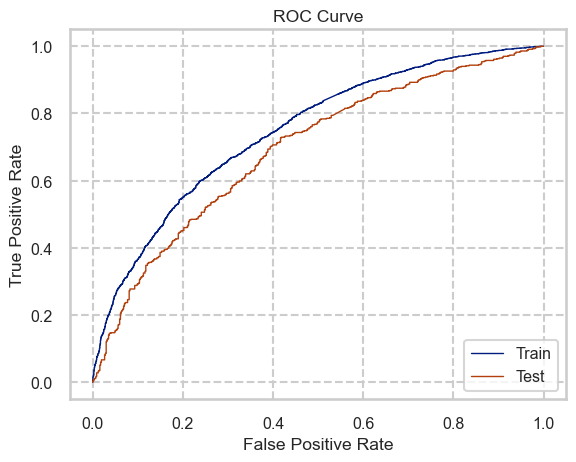

In [43]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/elastic_auroc.pgf')

# Non-linear Models

## Support Vector Machine

In [48]:
grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 2]
}

model_svm = GridSearchCV(SVC(), param_grid=grid)

In [49]:
model_svm.fit(X_train_tf, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 2], 'kernel': ['linear', 'poly', 'rbf']})

In [50]:
model_svm.best_params_

{'C': 2, 'kernel': 'rbf'}

In [51]:
y_train_preds = model_svm.predict(X_train_tf)
y_test_preds = model_svm.predict(X_test_tf)

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [53]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.8652882205513786 0.6502636203866433
Accuracy	 0.8652882205513784 0.6502636203866432
Precission	 0.9370314842578711 0.6807610993657506
Recall		 0.7832080200501254 0.5659050966608085


## Multi-layer Perceptron

In [54]:
grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.01,0.001,0.0001]
}

model_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=(10, 2)), param_grid=grid)

In [55]:
model_mlp.fit(X_train_tf, y_train)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(10, 2)),
             param_grid={'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'learning_rate_init': [0.01, 0.001, 0.0001],
                         'solver': ['adam', 'sgd', 'lbfgs']})

In [56]:
model_mlp.best_params_

{'alpha': 1e-05, 'learning_rate_init': 0.001, 'solver': 'sgd'}

In [57]:
y_train_preds = model_mlp.predict(X_train_tf)
y_test_preds = model_mlp.predict(X_test_tf)

In [58]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [59]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.9786967418546366 0.6001757469244289
Accuracy	 0.9786967418546366 0.6001757469244289
Precission	 0.9918454935622317 0.6079545454545454
Recall		 0.9653299916457811 0.5641476274165202


## Random Forest

In [60]:
grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 200, 300]
}
model_rf = GridSearchCV(RandomForestClassifier(bootstrap=False), param_grid=grid)

In [61]:
model_rf.fit(X_train_tf, y_train)

GridSearchCV(estimator=RandomForestClassifier(bootstrap=False),
             param_grid={'max_depth': [10, 20, 30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]})

In [62]:
model_rf.best_params_

{'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [63]:
y_train_preds = model_rf.predict(X_train_tf)
y_test_preds = model_rf.predict(X_test_tf)

In [64]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [65]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.9899749373433584 0.6458699472759226
Accuracy	 0.9899749373433584 0.6458699472759226
Precission	 0.9995741056218058 0.6378737541528239
Recall		 0.9803675856307436 0.6748681898066784


## Naive Bayes

In [66]:
grid = {'alpha': [10, 1, 0, 0.1, 0.01, 0.001]}

model_nb = GridSearchCV(MultinomialNB(), param_grid=grid)

In [67]:
model_nb.fit(X_train_tf, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [10, 1, 0, 0.1, 0.01, 0.001]})

In [68]:
model_nb.best_params_

{'alpha': 10}

In [69]:
y_train_preds = model_nb.predict(X_train_tf)
y_test_preds = model_nb.predict(X_test_tf)

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [71]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.6528822055137845 0.6282952548330405
Accuracy	 0.6528822055137845 0.6282952548330404
Precission	 0.6686635944700461 0.646
Recall		 0.6060985797827904 0.5676625659050967


There is no improvement when using the whole Dataset with ComplementNB, same scores on test

## XGBoost

In [72]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'eta': [0.1,0.01,0.001,0.0001]
}

model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)

In [73]:
model_xgb.fit(X_train_tf, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'alpha': [10, 1, 0, 0.1, 0.01, 0.001]})

In [74]:
y_train_preds = model_xgb.predict(X_train_tf)
y_test_preds = model_xgb.predict(X_test_tf)

In [75]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [76]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.9835004177109442 0.6001757469244288
Accuracy	 0.983500417710944 0.6001757469244289
Precission	 0.9919252018699533 0.6032608695652174
Recall		 0.974937343358396 0.5852372583479789
